# 2D convolution network with Adam optimizer (Functional model)



## This notebook is based on idea of AlexNet, the winner of ILSVRC 2012 - The ImageNet Large Scale Visual Recognition Challenge

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia/'
# path = '/Users/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

Using TensorFlow backend.


['woodOnRed', 'blackOnRed', 'redOnRed', 'redOnRed_white', 'navyOnWhite', 'blackOnBlack', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'stainOnWhite', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed', 'greenOnGreen']
100800


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [3]:
print(immatrix.shape)

(100800, 4096)


In [4]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [5]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

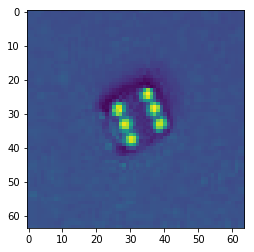

There are 6 dots, number is 11990


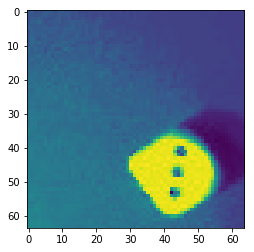

There are 3 dots, number is 57976


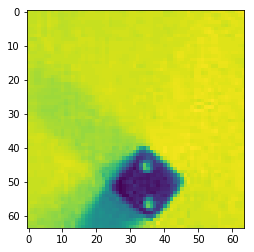

There are 2 dots, number is 39445


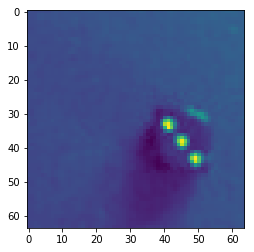

There are 3 dots, number is 28790


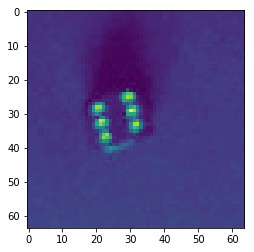

There are 6 dots, number is 33805


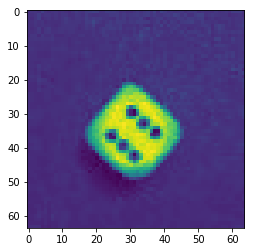

There are 6 dots, number is 92353


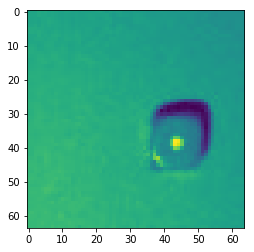

There are 1 dots, number is 93613


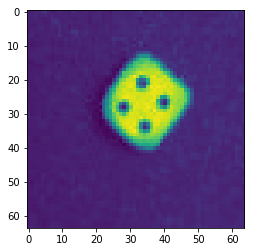

There are 4 dots, number is 84100


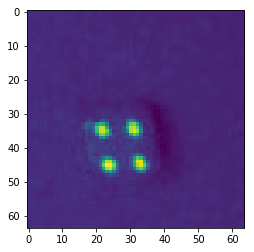

There are 4 dots, number is 18711


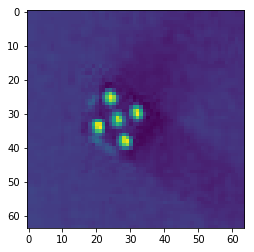

There are 5 dots, number is 32357


In [6]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 100800)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [7]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [8]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], rows, cols, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], rows, cols, 1).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(80640, 64, 64, 1) (20160, 64, 64, 1)


In [9]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(80640, 6) (20160, 6)


In [10]:
# create functional model with 2NN layers

visible = Input(shape=(64, 64, 1))

conv1 = Conv2D(64, kernel_size=7, padding='same', activation='relu')(visible)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(128, kernel_size=5, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
dropout1 = Dropout(0.2)(pool2)
conv3 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(dropout1)
dropout2 = Dropout(0.2)(conv3)
conv4 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(dropout2)
pool3 = MaxPooling2D((2, 2))(conv4)
flat1 = Flatten()(pool3)
hidden1 = Dense(1024, kernel_initializer='random_uniform', activation='relu')(flat1)
dropout3 = Dropout(0.2)(hidden1)
hidden2 = Dense(256, kernel_initializer='random_uniform', activation='relu')(dropout3)
dropout4 = Dropout(0.2)(hidden2)
hidden3 = Dense(64, kernel_initializer='random_uniform', activation='relu')(dropout4)
predictions = Dense(labels_values, activation='softmax')(hidden3)
model = Model(inputs=visible, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
# summarize model and apply checkpoints
print(model.summary())
filepath = 'dice_AlexNet-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
__________

In [12]:
# visualization of a model
plot_model(model, to_file='dice_AlexNet_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=1024, verbose=1, callbacks=callbacks_list)

Train on 80640 samples, validate on 20160 samples
Epoch 1/25
80640/80640 [==============================] - 108s 1ms/step - loss: 1.7787 - acc: 0.1960 - val_loss: 1.7853 - val_acc: 0.1829
Epoch 2/25
80640/80640 [==============================] - 94s 1ms/step - loss: 1.7842 - acc: 0.1767 - val_loss: 1.7872 - val_acc: 0.1678
Epoch 3/25
80640/80640 [==============================] - 94s 1ms/step - loss: 1.7618 - acc: 0.2048 - val_loss: 1.7926 - val_acc: 0.1660
Epoch 4/25
80640/80640 [==============================] - 93s 1ms/step - loss: 1.7922 - acc: 0.1670 - val_loss: 1.7918 - val_acc: 0.1661
Epoch 5/25
80640/80640 [==============================] - 93s 1ms/step - loss: 1.7918 - acc: 0.1667 - val_loss: 1.7918 - val_acc: 0.1661
Epoch 6/25
80640/80640 [==============================] - 93s 1ms/step - loss: 1.7918 - acc: 0.1661 - val_loss: 1.7918 - val_acc: 0.1661
Epoch 7/25
80640/80640 [==============================] - 93s 1ms/step - loss: 1.7918 - acc: 0.1655 - val_loss: 1.7918 - val_ac

In [14]:
score = model.evaluate(X_test, y_test, verbose=1)

20160/20160 [==============================] - 10s 475us/step


In [15]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])
Accuracy: 98.89%
Test loss: 0.033052652485766595
Test accuracy 0.9888888888888889


In [16]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 0.033052652485766595
acc: 0.9888888888888889


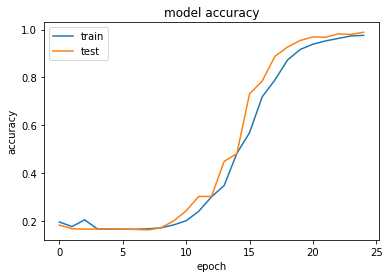

In [17]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

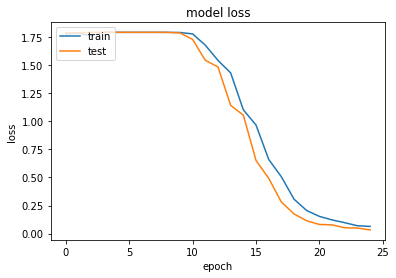

In [18]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model_json = model.to_json()
with open('dice_AlexNet_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('dice_AlexNet_weights.h5')
print('Saved model weights')

Saved model weights


In [ ]:
new_model = load_model('model2-25-0.0074.h5')
# check in models are similar to the given tolerance
# assert_allclose(model.predict(X_train),
#                new_model.predict(X_train),
#                1e-4)

In [ ]:
filepath = 'model2API_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

In [ ]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))


In [ ]:
model_json = model.to_json()
with open('model2API_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2API_weights_continue.h5')
print('Saved model weights')